In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

2023-11-26 17:50:03.059780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 17:50:09.405800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 17:50:09.405914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 17:50:09.754958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 17:50:14.027220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 17:50:14.048155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 3591 files belonging to 2 classes.


In [3]:
batch = data.as_numpy_iterator().next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])

In [3]:
data = data.map(lambda x,y: (x/255, y))

In [4]:
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.2)
val_size = int(len(data) * 0.1)

In [5]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom

In [7]:
res_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 9s 0us/step


In [15]:
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [19]:
for l in res_model.layers:
    l.trainable = False

In [20]:
model = Sequential()
# model.add(RandomFlip("horizontal_and_vertical"))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))
model.add(res_model)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, Precision, Recall

In [12]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=[BinaryAccuracy(), Accuracy(), Precision(), Recall()])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9

In [14]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-11-26 17:56:50.991579: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-11-26 17:56:51.026006: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-11-26 17:56:51.121703: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-11-26 17:56:51.220746: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-11-26 17:56:51.220875: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


 7/79 [=>............................] - ETA: 4:26 - loss: 0.3508 - binary_accuracy: 0.8170 - accuracy: 0.0000e+00 - precision: 0.8561 - recall: 0.8370

KeyboardInterrupt: 

In [25]:
model.save('models/resnet.keras')

In [16]:
test_hist = model.evaluate(test)

22/22 [==============================] - 80s 1s/step - loss: 0.2938 - binary_accuracy: 0.8722 - accuracy: 0.0000e+00 - precision: 0.8624 - recall: 0.9117


In [6]:
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow_model_analysis as tfma

In [8]:
model = load_model('models/vitiligoDetector.keras')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9

In [1]:
import tensorflow as tf
import numpy as np

2023-11-06 19:00:56.447730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 19:00:56.493273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 19:00:56.493340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 19:00:56.493370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 19:00:56.502339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 19:00:56.503555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

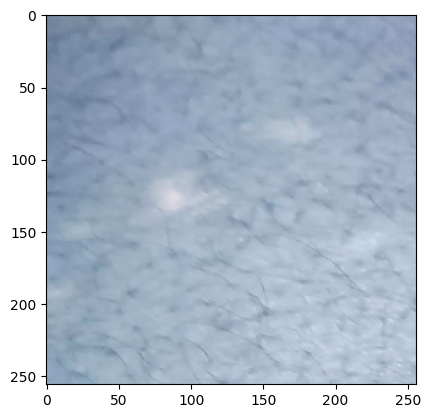

In [31]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('vit2.jpeg')

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [32]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 155ms/step


array([[0.7746718]], dtype=float32)